In [1]:
# Importing Necessary Libraries
import tensorflow
import google
import cv2
import PIL
import matplotlib
import numpy
import pandas
import sklearn
import os
import glob

In [2]:
# Kaggle API Authentication
!pip install -q kaggle
google.colab.files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
# Downloading and Unzipping The Dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip

100% 5.20G/5.20G [01:48<00:00, 21.8MB/s]
100% 5.20G/5.20G [01:48<00:00, 51.4MB/s]


In [4]:
# Dataset Preprocessing
base_directory = os.path.join("/content")

image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob.glob(os.path.join(base_directory, '*', '*.jpg'))}

lesions = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}     

dataframe = pandas.read_csv(os.path.join(base_directory, 'HAM10000_metadata.csv'))

dataframe['path'] = dataframe['image_id'].map(image_paths.get)
dataframe['cell_type'] = dataframe['dx'].map(lesions.get) 
dataframe['cell_type_idx'] = pandas.Categorical(dataframe['cell_type']).codes

dataframe.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [5]:
# Checking For Empty Values
dataframe.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
# Filling In Empty Values 
dataframe['age'].fillna((dataframe['age'].mean()), inplace = True)

In [7]:
# Checking for Empty Values 
dataframe.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [8]:
# Reshaping Image Sizes to (100, 75) To Prevent Exceeding RAM Limit
dataframe['image'] = dataframe['path'].map(lambda x: numpy.asarray(PIL.Image.open(x).resize((100, 75))))

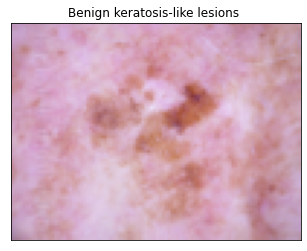

In [9]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][0])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][0])
matplotlib.pyplot.show()

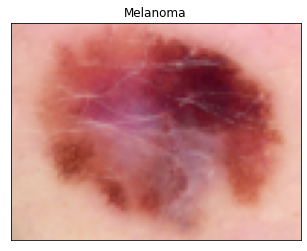

In [10]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][2000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][2000])
matplotlib.pyplot.show()

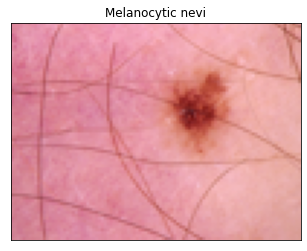

In [11]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][3000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][3000])
matplotlib.pyplot.show()

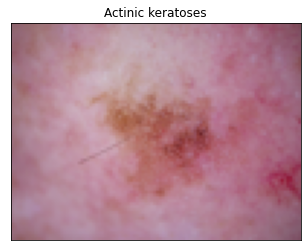

In [12]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][10000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][10000])
matplotlib.pyplot.show()

In [13]:
# Preprocessing Data
from sklearn.model_selection import train_test_split
features = dataframe.drop(columns = ['cell_type_idx'], axis = 1)
target = dataframe['cell_type_idx']

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.1)

X_train = numpy.asarray(X_train_o['image'].tolist())
X_test = numpy.asarray(X_test_o['image'].tolist())

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))

y_train = tensorflow.keras.utils.to_categorical(y_train_o, num_classes = 7)
y_test = tensorflow.keras.utils.to_categorical(y_test_o, num_classes = 7)

In [14]:
# Data Augmentation
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

In [15]:
training_image_generator = image_generator.flow(X_train, y_train)

In [22]:
# Initializing MobileNet 
mobilenet = tensorflow.keras.applications.mobilenet.MobileNet(input_shape = (75, 100, 3), include_top = False)
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 38, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 38, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 38, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 38, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 38, 50, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 38, 50, 32) 

In [55]:
# Specializing MobileNet for HAM-10000 Dataset
x = mobilenet.layers[-6].output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(units = 1028, activation = "relu")(x)
x = tensorflow.keras.layers.Dense(units = 1028, activation = "relu")(x)
predictions = tensorflow.keras.layers.Dense(units = 7, activation = "softmax")(x)

model = tensorflow.keras.models.Model(inputs = mobilenet.input, outputs = predictions)

In [56]:
# Freezing Base Layers
for layer in model.layers[:-23]:
  layer.trainable = False

In [57]:
# Compiling MobileNet
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [58]:
# Training MobileNet
model.fit(training_image_generator, epochs = 10, callbacks = tensorflow.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "min", restore_best_weights = True))

Epoch 1/10
282/282 [==============================] - 18s 59ms/step - loss: 0.3883 - accuracy: 0.8757
Epoch 2/10
282/282 [==============================] - 17s 59ms/step - loss: 0.1945 - accuracy: 0.9329
Epoch 3/10
282/282 [==============================] - 17s 59ms/step - loss: 0.2017 - accuracy: 0.9300
Epoch 4/10
282/282 [==============================] - 17s 59ms/step - loss: 0.1984 - accuracy: 0.9309
Epoch 5/10
282/282 [==============================] - 17s 59ms/step - loss: 0.1880 - accuracy: 0.9338
Epoch 6/10
282/282 [==============================] - 17s 59ms/step - loss: 0.2092 - accuracy: 0.9283
Epoch 7/10
282/282 [==============================] - 17s 59ms/step - loss: 0.2004 - accuracy: 0.9316
Epoch 8/10
282/282 [==============================] - 17s 59ms/step - loss: 0.2032 - accuracy: 0.9238


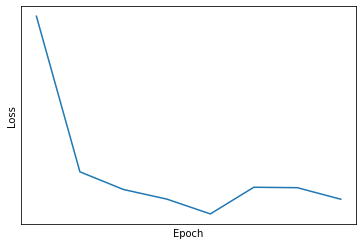

In [59]:
# Visualizing The Optimization
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(model.history.epoch, model.history.history["loss"])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.yticks([])
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.show()

In [60]:
# Initializing Testing Image Generator
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator()
testing_image_generator = image_generator.flow(X_test, y_test)

In [62]:
# Examining The Testing Accuracy
print("Testing Accuracy: {}%".format(((model.evaluate(testing_image_generator)[1] * 100))))

32/32 [==============================] - 1s 10ms/step - loss: 0.6549 - accuracy: 0.8383
Testing Accuracy: 83.83233547210693%


In [63]:
# Visualizing a Random Prediction
def visualize_prediction(file_path, actual): 
  matplotlib.pyplot.figure() 
  image = numpy.asarray(PIL.Image.open(file_path).resize((100, 75)))
  matplotlib.pyplot.imshow(image)
  image = image / 255.0
  image = numpy.resize(image, (1, 75, 100, 3))
  prediction = model.predict(image).argmax()
  classes = {0: "Actinic Keratoses/Intraepithelial Carcinoma (akiec)",
             1: "Basal Cell Carcinoma (bcc)",
             2: "Benign Keratosis-Like Lesions (bkl)",
             3: "Dermatofibroma (df)",
             4: "Melanoma (mel)",
             5: "Melanocytic Nevi (nv)",
             6: "Vascular Lesions (vasc)"}
  prediction = classes[prediction]
  matplotlib.pyplot.xticks([])
  matplotlib.pyplot.title("Prediction: {}\nActual: {}".format(prediction, actual))
  matplotlib.pyplot.yticks([])
  matplotlib.pyplot.show()

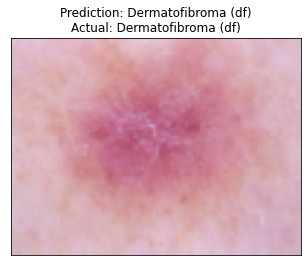

In [78]:
visualize_prediction(file_path = "/content/ham10000_images_part_1/ISIC_0025594.jpg", actual = "Dermatofibroma (df)")

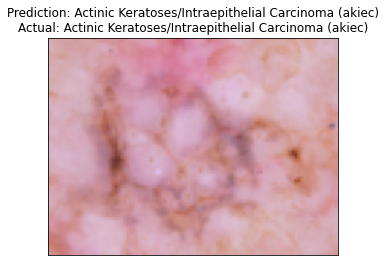

In [79]:
visualize_prediction(file_path = "/content/HAM10000_images_part_2/ISIC_0031040.jpg", actual = "Actinic Keratoses/Intraepithelial Carcinoma (akiec)")

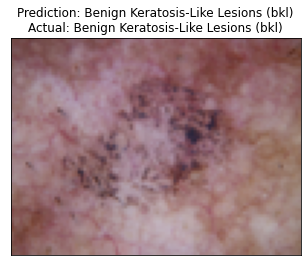

In [80]:
visualize_prediction(file_path = "/content/HAM10000_images_part_2/ISIC_0032445.jpg", actual = "Benign Keratosis-Like Lesions (bkl)")

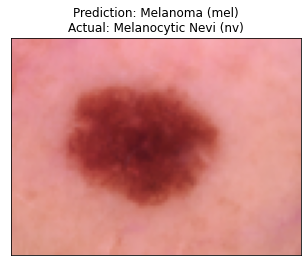

In [82]:
visualize_prediction(file_path = "/content/ham10000_images_part_1/ISIC_0026073.jpg", actual = "Melanocytic Nevi (nv)")

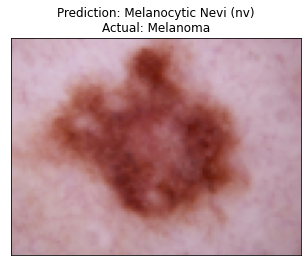

In [91]:
visualize_prediction(file_path = "/content/HAM10000_images_part_2/ISIC_0032504.jpg", actual = "Melanoma")

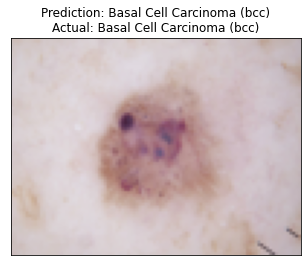

In [95]:
visualize_prediction(file_path = "/content/ham10000_images_part_1/ISIC_0025818.jpg", actual = "Basal Cell Carcinoma (bcc)")

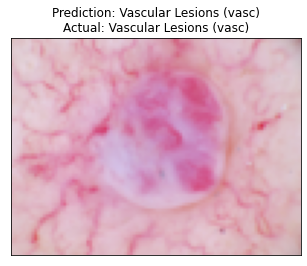

In [96]:
visualize_prediction(file_path = "/content/ham10000_images_part_1/ISIC_0026456.jpg", actual = "Vascular Lesions (vasc)")

In [97]:
model.save("HAM-10000_MobileNet.h5")

**Clarification**

The model had a hard time differentiating between Melanoma (mel) and Melanocytic Nevi (nv). Actually, Melanoma (mel) is a form of Melanocytic Nevi (nv). So it is understandable why the model is confused between these two.